# PET/CT and CT-derived facial landmark identification

*MVA Project 2022-2023*

*Authors: Emma Bou Hanna & Sebastian Partarrieu*

In this notebook, we use PET and CT scans to perform facial reconstruction. The main focus here is to explore the possibility of identifying facial landmarks on the reconstructed faces. We use this as a metric for facial reconstruction as well-reconstructed faces will give good landmark identification. 

## Data imports

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd gdrive/MyDrive/MVA/projet_medecin/

/content/gdrive/MyDrive/MVA/projet_medecin


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F

In [4]:
## store all filenames
list_ct_names = []
list_ct_res_names = [] 
list_suv_names = []
for path, subdirs, files in os.walk("./subset_emma_sebastian"):
  for fname in files:
    if fname.startswith('CTres'):
      list_ct_res_names.append(os.path.join(path, fname))
    elif fname.startswith('CT'):
      list_ct_names.append(os.path.join(path, fname))
    elif fname.startswith('SUV'):
      list_suv_names.append(os.path.join(path, fname))

In [5]:
ct_scans = np.array(list_ct_res_names)
pet_scans = np.array(list_suv_names)

## Helpers

In [6]:
from skimage.filters import threshold_otsu, threshold_multiotsu
import seaborn as sns
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
sns.set_style('dark')

In [7]:
!pip install connected-components-3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 30.3 MB/s eta 0:00:00


In [8]:
!pip install open3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.5/422.5 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.0 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.7.3
    Uninstalling nbformat-5.7.3:
      Successfully uninstalled nbformat-5.7.3


In [9]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 15.2 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 23.1.21 which is incompatible.


In [11]:
import cc3d
import open3d as o3d
from skimage.color import rgb2gray
import cv2
from skimage import measure
import mediapipe as mp

In [12]:
def generate_mesh(data, voxel_spacing):
  '''
  Give mesh from voxel data.
  (i) take largest connected component (aside from background)
  (ii) apply marching cubes for surface segmentation
  (iii) convert to mesh
  (iv) some light postprocessing on the mesh
  '''
  # largest connected component
  labels = cc3d.connected_components(data)
  morpho = labels.copy()
  unique_lab, counts = np.unique(labels, return_counts=True)
  skin = unique_lab[np.argsort(counts)[-2]] # first largest comp is background
  morpho = (morpho == skin).astype(float)
  # marching cubes
  verts, faces, normals, vals = measure.marching_cubes(morpho, .5, spacing=voxel_spacing)
  # mesh
  mesh = o3d.geometry.TriangleMesh()
  mesh.vertices = o3d.utility.Vector3dVector(verts)
  mesh.triangles = o3d.utility.Vector3iVector(faces)
  mesh.compute_vertex_normals()
  # postprocessing
  mesh_out = mesh.filter_smooth_laplacian(number_of_iterations=5)
  mesh_out.compute_vertex_normals()
  return mesh_out

In [13]:
def ray_casting(mesh, voxel_spacing, height, out_width=256, out_height=256):
  '''
  From o3d.geometry.TriangleMesh do raycasting to create a
  visualization of the patients face.
  '''
  mesh_f = o3d.t.geometry.TriangleMesh.from_legacy(mesh.translate([0, 0, 0]))

  scene = o3d.t.geometry.RaycastingScene()
  person_id = scene.add_triangles(mesh_f)

  rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
    fov_deg=90,
    center=[200*voxel_spacing[0], 0, height*voxel_spacing[-1]],
    eye=[200*voxel_spacing[0], 400*voxel_spacing[1], height*1.01*voxel_spacing[2]],
    up=[0, 1, 0],
    width_px=out_width,
    height_px=out_height)
  
  ans = scene.cast_rays(rays)
  img = np.abs(ans['primitive_normals'].numpy())
  return img

In [14]:
def to_gray_uint(image):
    return np.uint8(rgb2gray(image) * 255)

In [23]:
def add_face_box_to_img(image):
  '''
  Face bounding box obtained with open cv haar cascades.
  Image modified inplace!
  '''
  gray_img = to_gray_uint(image)
  face_cascade_name = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
  haar_cascade = cv2.CascadeClassifier(face_cascade_name)
  faces_rect = haar_cascade.detectMultiScale(gray_img, scaleFactor = 1.1,
                                             minNeighbors = 3, minSize=(70, 70))
  color_img = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2RGB)
  for (x,y,w,h) in faces_rect:
     cv2.rectangle(color_img, (x, y), (x+w, y+h), (220, 20, 60), 2)
  return color_img, faces_rect

In [24]:
def add_facial_landmarks(mp_drawing,
                         mp_face_mesh,
                         mp_drawing_styles,
                         results, image):
  if results.multi_face_landmarks:
    counter = 0
    for face_landmarks in results.multi_face_landmarks:
      mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())
      mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
      counter += 1
      return image, counter
  else:
    return image, 0

In [25]:
def plot(img1, img2, title1, title2):
  f, axs = plt.subplots(1, 2, figsize=(12, 6))
  axs[0].imshow(img1, cmap='gray')
  axs[0].axis('off')
  axs[0].set(title=title1)

  axs[1].imshow(img2, cmap='gray')
  axs[1].axis('off')
  axs[1].set(title=title2)
  plt.show()

## Facial landmarks

In [18]:
nb_face_detected_pet = 0
nb_face_detected_ct = 0

In [19]:
landmarks_detected_pet = 0
landmarks_detected_ct = 0

In [26]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True,
                                  max_num_faces=1,
                                  refine_landmarks=True,
                                  min_detection_confidence=0.3)

In [27]:
for pet, ct in zip(pet_scans, ct_scans):
  print('Processing patient '+str(pet))

  #read data
  pet_file, ct_file = nib.load(pet), nib.load(ct)
  pet_img = pet_file.get_fdata()
  ct_data = ct_file.get_fdata()

  #get vox dims
  pet_voxel_spacing = pet_file.header.get_zooms()
  ct_voxel_spacing = ct_file.header.get_zooms()

  print(pet_voxel_spacing, ct_voxel_spacing)
  #thresholds
  ct_thresh = threshold_otsu(ct_data)
  ct_thresholded = ct_data >= ct_thresh

  pet_perc = np.percentile(pet_img.flatten(), 95)
  pet_tresholded = pet_img >= pet_perc

  #cut image
  height_ct = ct_thresholded.shape[-1]//8
  height_pet = pet_tresholded.shape[-1]//8

  ct_thresholded = ct_thresholded[:, :, -ct_thresholded.shape[-1]//4:]
  pet_tresholded = pet_tresholded[:, :, -pet_tresholded.shape[-1]//4:]

  #get both meshes
  mesh_ct = generate_mesh(ct_thresholded, ct_voxel_spacing)
  mesh_pet = generate_mesh(pet_tresholded, pet_voxel_spacing)

  #ray casting
  ct_img = ray_casting(mesh_ct, ct_voxel_spacing, height_ct, out_width=512, out_height=512)
  pet_img = ray_casting(mesh_pet, pet_voxel_spacing, height_pet, out_width=512, out_height=512)

  #face detection
  ct_img, faces_ct = add_face_box_to_img(ct_img)
  pet_img, faces_pet = add_face_box_to_img(pet_img)

  #update
  if len(faces_ct) == 1:
    nb_face_detected_ct += 1
  if len(faces_pet) == 1:
    nb_face_detected_pet += 1

  #plot
  plot(ct_img, pet_img, 'CT face detection', 'PET face detection')
  
  #facial landmarks
  results_ct = face_mesh.process(ct_img)
  results_pet = face_mesh.process(pet_img)
  
  #add to plot
  ct_img, counter_landmarks_ct = add_facial_landmarks(mp_drawing,
                                mp_face_mesh,
                                mp_drawing_styles,
                                results_ct, ct_img)
  
  pet_img, counter_landmarks_pet = add_facial_landmarks(mp_drawing,
                                mp_face_mesh,
                                mp_drawing_styles,
                                results_pet, pet_img)
  
  #update
  if counter_landmarks_ct == 1:
    landmarks_detected_ct += 1

  if counter_landmarks_pet == 1:
    landmarks_detected_pet += 1

  if (counter_landmarks_ct == 1) or (counter_landmarks_pet == 1):
    plot(ct_img, pet_img, 'CT face detection', 'PET face detection')

Output hidden; open in https://colab.research.google.com to view.

In [28]:
len(pet_scans)

56

In [33]:
height = [nb_face_detected_ct/56,
          nb_face_detected_pet/56,
          landmarks_detected_ct/56,
          landmarks_detected_pet/56]

bars = ['CT face detection',
        'PET face detection',
        'CT landmarks',
        'PET landmarks']

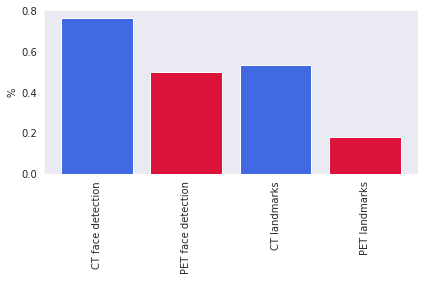

In [35]:

plt.bar(np.arange(len(bars)), height,
        color=['royalblue', 'crimson', 'royalblue', 'crimson'])
plt.xticks(np.arange(len(bars)), bars, rotation=90)
plt.ylabel('%')
plt.tight_layout()
plt.savefig('./figs/face_boxplots.png', dpi=300)
plt.show()

In [29]:
landmarks_detected_ct

30

In [30]:
landmarks_detected_pet

10

In [31]:
nb_face_detected_ct

43

In [32]:
nb_face_detected_pet

28

In [ ]:
landmarks_detected_ct

14

In [ ]:
landmarks_detected_pet

2

In [ ]:
nb_face_detected_ct

43

In [ ]:
nb_face_detected_pet

31